In [4]:
import sqlite3  # for connecting and reading database file
import matplotlib.pyplot as plt  # for making plots
import matplotlib.patches as mpatches
import seaborn as sns  # for making graphics on our plot
import pandas as pd  # spreadsheets for manipulating data
import PySimpleGUI as sg # for extracting screen dimensions
from dateutil import parser  # for turning date strings into datetime objects
from datetime import datetime, timedelta  # for using datetime objects
from dataclasses import dataclass # for making drawing dimensions sets

db_path = r"C:\Users\adankert\Google Drive\GitHub\archives_archiver\dev_files\archives_archiver.db"
conn = sqlite3.connect(db_path)

archived_files_df = pd.read_sql('''SELECT * FROM archived_files''', conn)
archivists_df = pd.read_sql('''SELECT * FROM archivists''', conn)
conn.close()

# This is for creating a column of archivist emails in the archived_files_df
archived_files_df["archivist_email"] = ""
id_df = None
for idx, row in archived_files_df.iterrows():  # loop over dataframe rows
    archivist_id = row["archivist_id"]
    id_df = archivists_df[archivists_df["id"] == archivist_id]
    archivist_email = id_df["email"].iloc[0]
    archived_files_df.at[idx, "archivist_email"] = archivist_email

# creates a column of datetime objects that have been created by parsing the string date in "date_archived" column
archived_files_df["archived_dt"] = archived_files_df["date_archived"].map(parser.parse)

# iterate through last 60 days adding up the number of files and quantity of data archived each day.
# This is held in list of dictionaries
daily_data = []
for x in range(0, 60):
    day = datetime.now() - timedelta(days=x)
    is_same_day = lambda dt: dt.date() == day.date()
    day_df = archived_files_df[archived_files_df["archived_dt"].map(is_same_day)]

    # create a dictionary of the values we will add to our dictionary
    day_row = {"datetime": day, "bytes_archived": day_df["file_size"].sum(), "files_archived": day_df.shape[0]}
    daily_data.append(day_row)

# create a dataframe of number of files and size of files archived per day
aggregate_daily_archived_df = pd.DataFrame(daily_data, columns=["datetime", "bytes_archived", "files_archived"])

daily_data = []
for x in range(0, 60):
    day = datetime.now() - timedelta(days=x)
    is_same_day = lambda dt: dt.date() == day.date()
    day_df = archived_files_df[archived_files_df["archived_dt"].map(is_same_day)]

    if day_df.shape[0] != 0:
        # create a dictionary of the values we will add to our dictionary
        day_row = {"datetime": day, "bytes_archived": day_df["file_size"].sum(), "files_archived": day_df.shape[0]}
        daily_data.append(day_row)

# create a dataframe of number of files and size of files archived per day
aggregate_daily_archived_df = pd.DataFrame(daily_data, columns=["datetime", "bytes_archived", "files_archived"])

bytes_to_megabytes = lambda b : b/1000000
aggregate_daily_archived_df["bytes_archived"] = aggregate_daily_archived_df["bytes_archived"].map(bytes_to_megabytes)



In [ ]:

def retrieve_screen_dims():
    return sg.Window.get_screen_size()


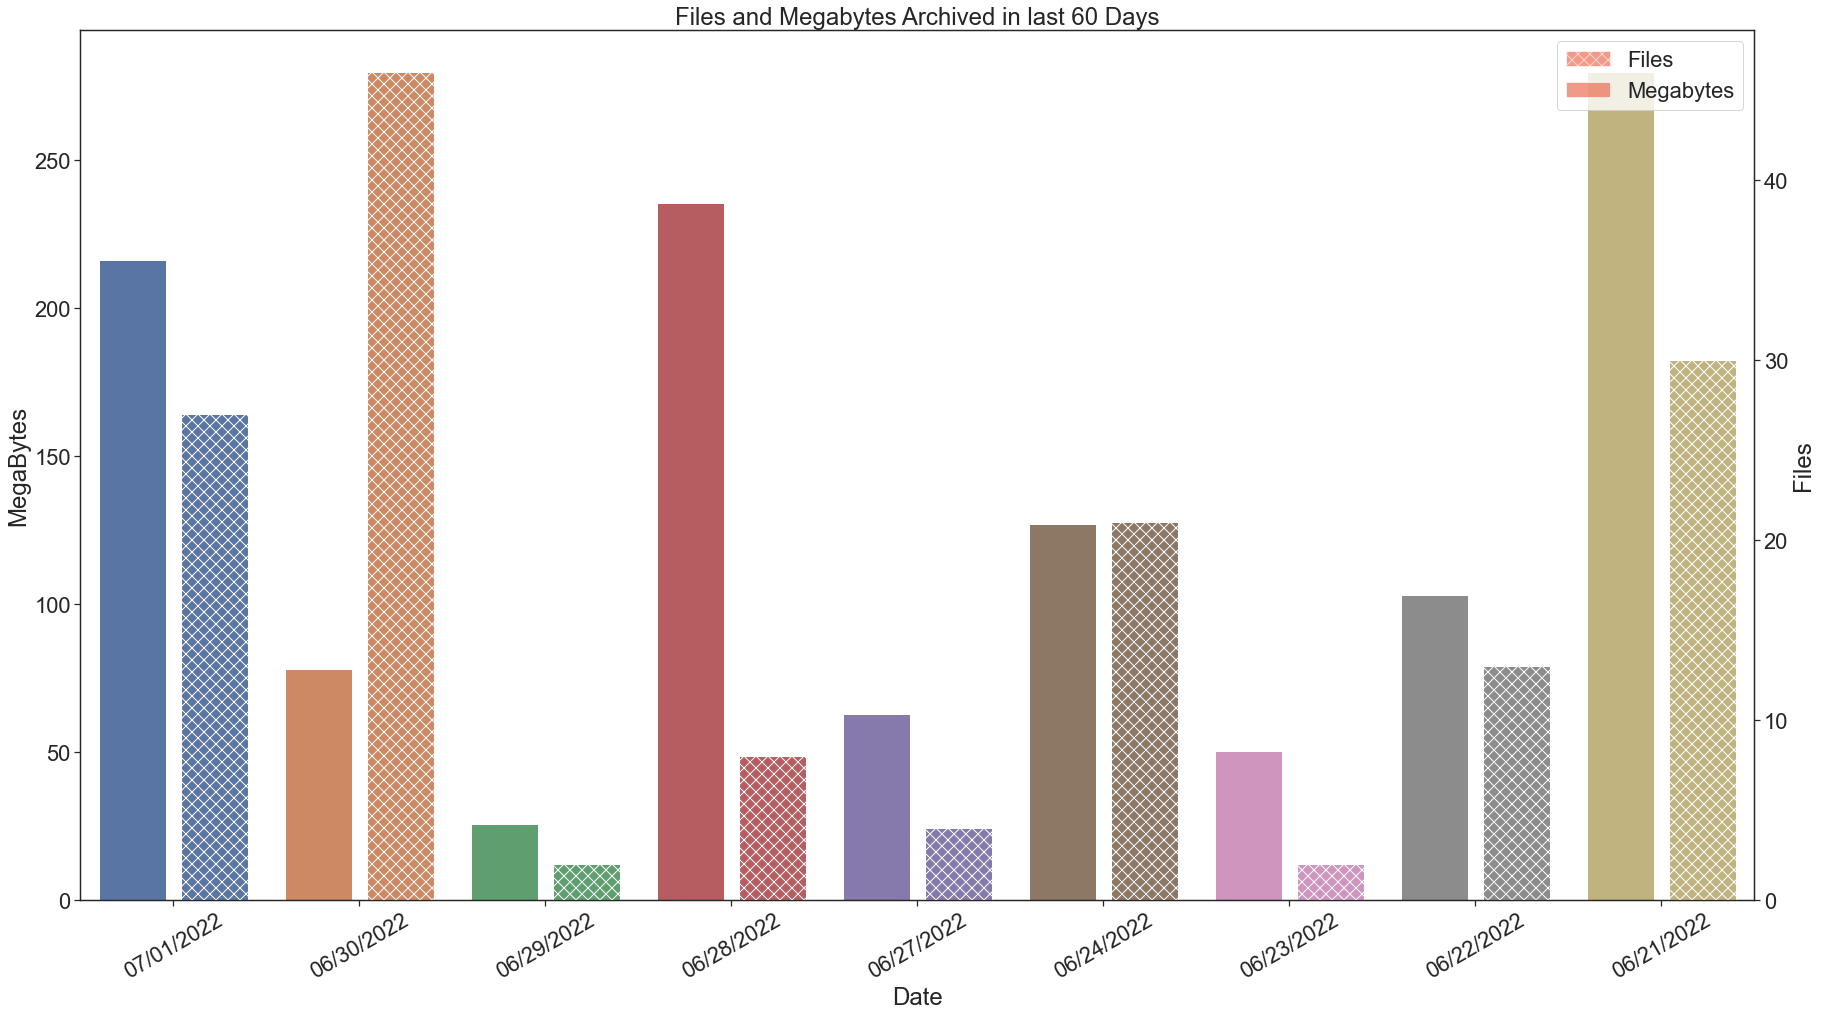

In [5]:
@dataclass
class DimSet:
    """
    """
    font_scale: int
    figsize: tuple
    width_scale: float

    def __init__(self, figsize, width_scale, font_scale):
        self.figsize = figsize
        self.width_scale = width_scale
        self.font_scale = font_scale


dim_choices = {1:DimSet(figsize=2, width_scale=.45, font_scale=2)}


sns.set(font_scale=2)
sns.set_style("ticks")
fig = plt.figure(figsize=(30,16))
bytes_axis = sns.barplot(x="datetime", y="bytes_archived", data=aggregate_daily_archived_df)
bytes_axis.set(title="Files and Megabytes Archived in last 60 Days", xlabel="Date", ylabel="MegaBytes")
width_scale = .45
for bar in bytes_axis.containers[0]:
    bar.set_width(bar.get_width() * width_scale)



file_num_axis = bytes_axis.twinx()
files_axis = sns.barplot(x="datetime", y="files_archived", data=aggregate_daily_archived_df, hatch='xx', ax=file_num_axis)
files_axis.set(ylabel="Files")
for bar in files_axis.containers[0]:
    bar_x = bar.get_x()
    bar_w = bar.get_width()
    bar.set_x(bar_x + bar_w * (1 - width_scale))
    bar.set_width(bar_w * width_scale)

#files_axis.set_xticklabels(files_axis.get_xticklabels(),rotation = 30)
reformat_label_str = lambda x: parser.parse(x.get_text()).strftime("%m/%d/%Y")
bytes_axis.set_xticklabels([reformat_label_str(x) for x in bytes_axis.get_xticklabels()],rotation = 30)

a_val = 0.6
colors = ['#EA5739','#FEFFBE','#4BB05C']
legend_patch_files = mpatches.Patch(facecolor=colors[0],alpha=a_val,hatch=r'xx',label='Files')
legend_patch_bytes = mpatches.Patch(facecolor=colors[0],alpha=a_val,label='Megabytes')

plt.legend(handles=[legend_patch_files, legend_patch_bytes])
plt.show()

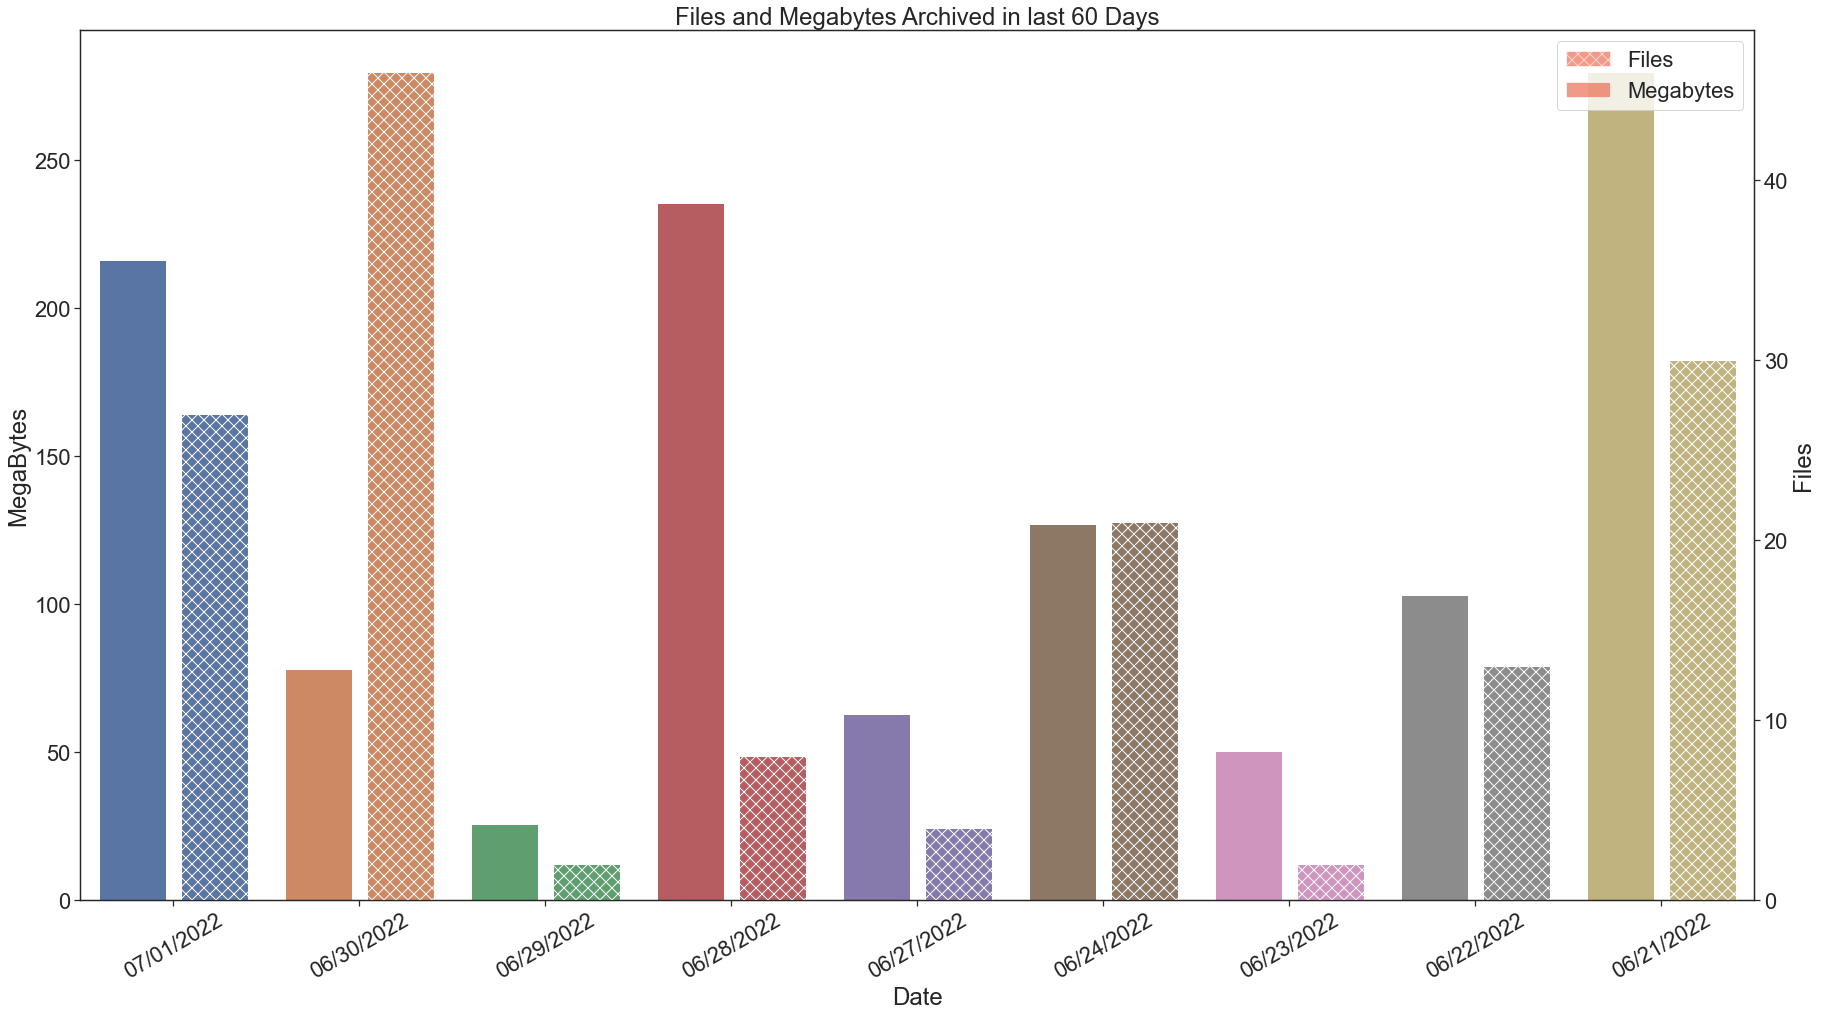

In [6]:
fig

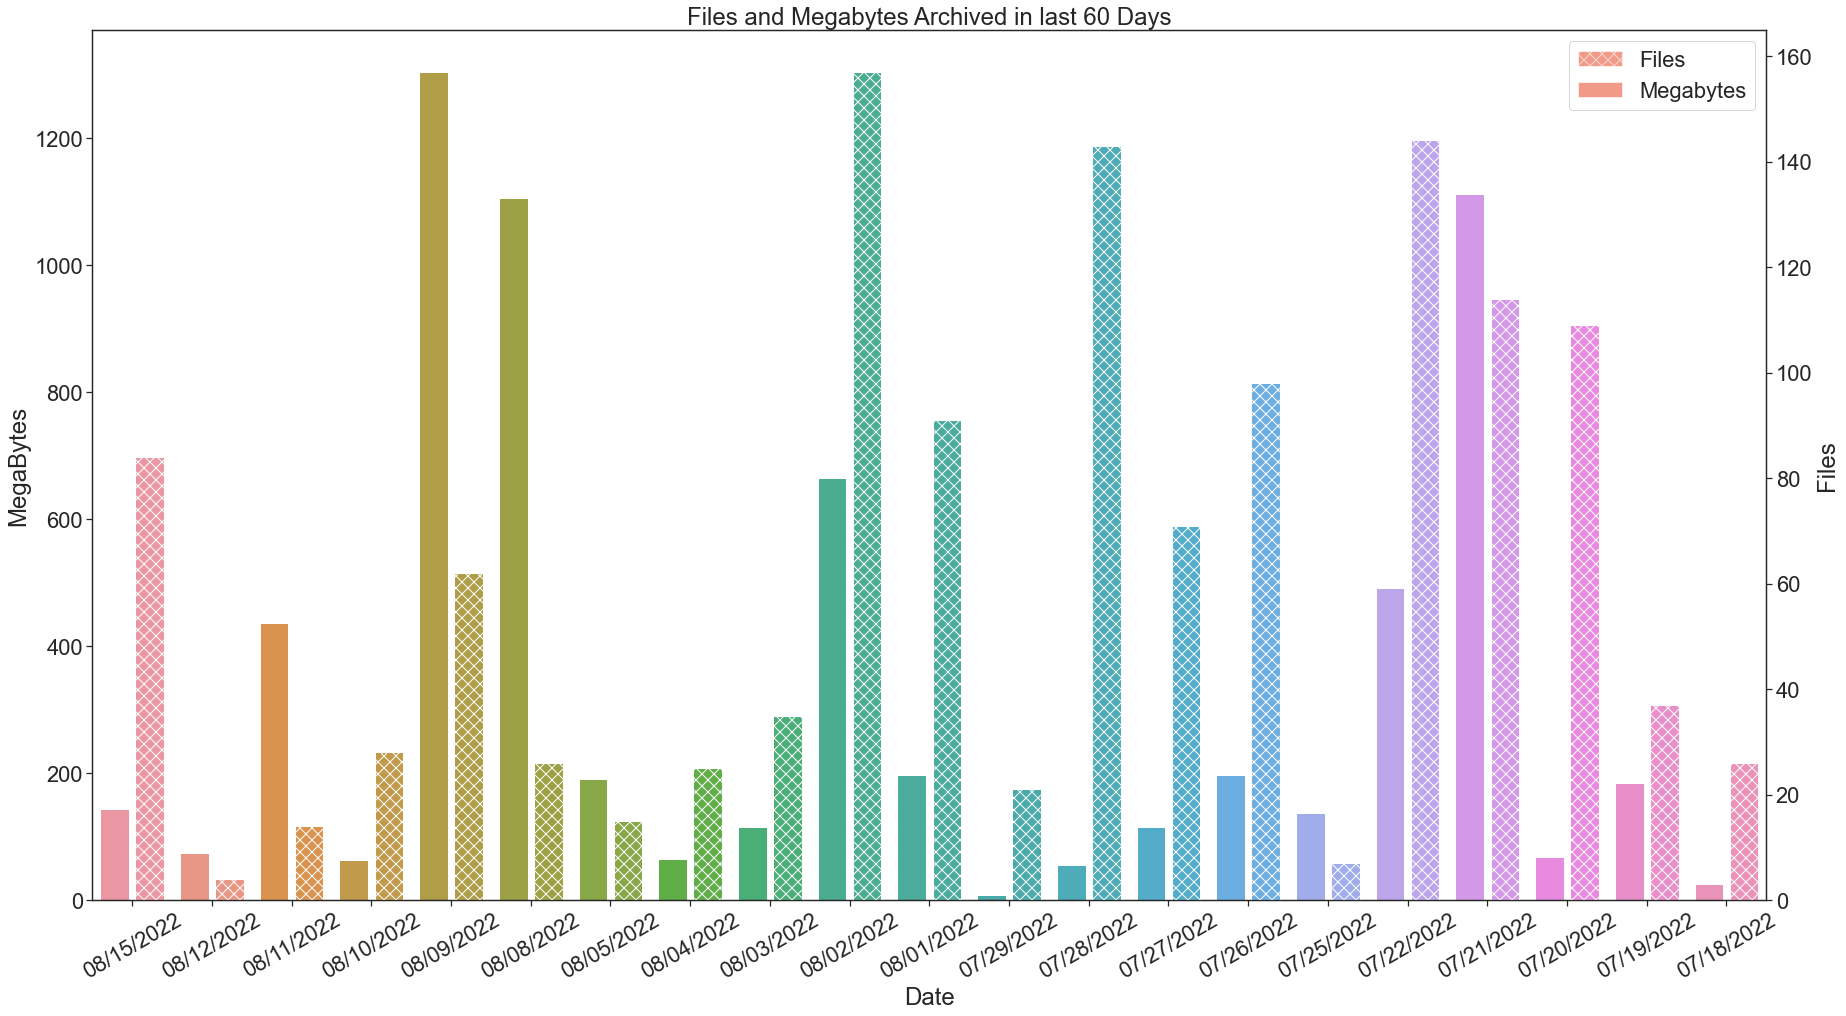

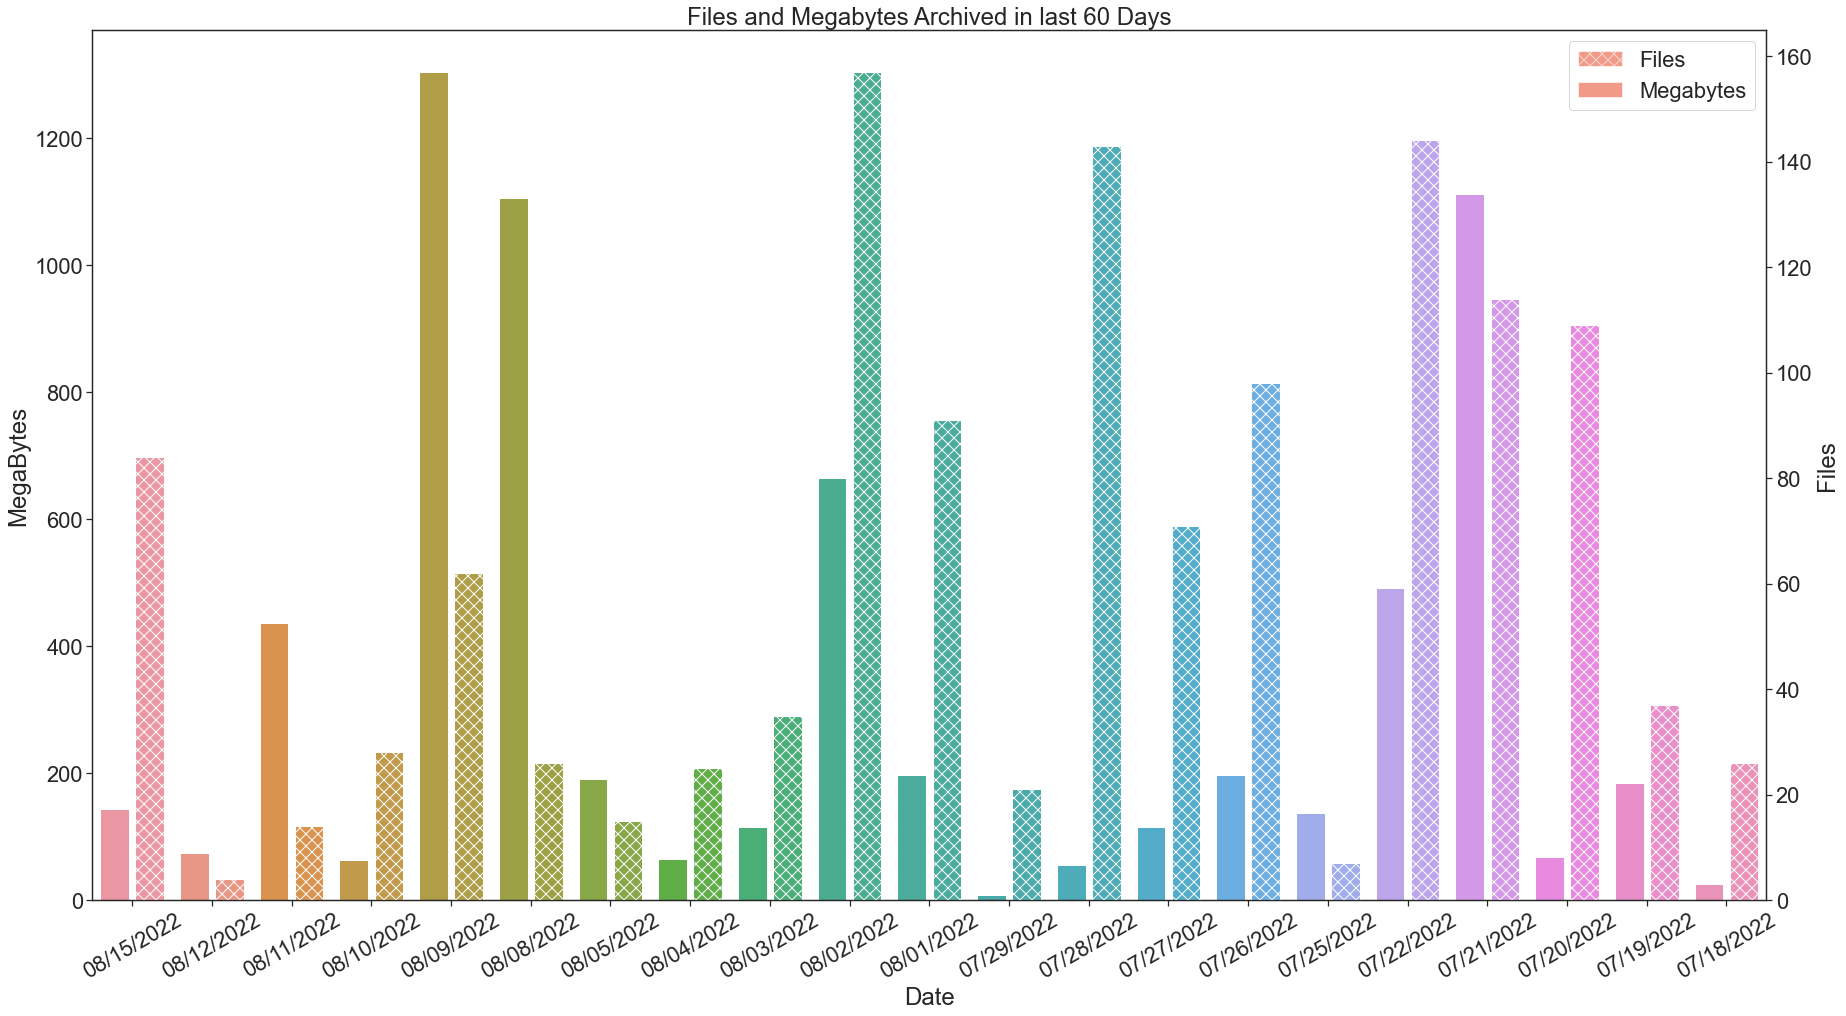

In [8]:
def generate_archived_stat_barchart(days=30):
    """

    :param days: Number of days with which to plot analysis
    :return:
    """
    def retrieve_screen_dims():
        return sg.Window.get_screen_size()

    def generate_daily_sum_dataframe(conn, days):
        # copy data to dataframes from database connection
        archived_files_df = pd.read_sql('''SELECT * FROM archived_files''', conn)
        archivists_df = pd.read_sql('''SELECT * FROM archivists''', conn)

        # This is for creating a column of archivist emails in the archived_files_df
        archived_files_df["archivist_email"] = ""
        id_df = None
        for idx, row in archived_files_df.iterrows():  # loop over dataframe rows
            archivist_id = row["archivist_id"]
            id_df = archivists_df[archivists_df["id"] == archivist_id]
            archivist_email = id_df["email"].iloc[0]
            archived_files_df.at[idx, "archivist_email"] = archivist_email

        # creates a column of datetime objects that have been created by parsing the string date in "date_archived" column
        archived_files_df["archived_dt"] = archived_files_df["date_archived"].map(parser.parse)
        daily_data = []
        for x in range(0, days):
            day = datetime.now() - timedelta(days=x)
            is_same_day = lambda dt: dt.date() == day.date()
            day_df = archived_files_df[archived_files_df["archived_dt"].map(is_same_day)]

            if day_df.shape[0] != 0:
                # create a dictionary of the values we will add to our dictionary
                day_row = {"datetime": day, "bytes_archived": day_df["file_size"].sum(),
                           "files_archived": day_df.shape[0]}
                daily_data.append(day_row)

        # create a dataframe of number of files and size of files archived per day
        aggregate_daily_archived_df = pd.DataFrame(daily_data, columns=["datetime", "bytes_archived", "files_archived"])

        bytes_to_megabytes = lambda b: b / 1000000
        aggregate_daily_archived_df["bytes_archived"] = aggregate_daily_archived_df["bytes_archived"].map(
            bytes_to_megabytes)
        return aggregate_daily_archived_df

    conn = sqlite3.connect(db_path)
    daily_sum_df = generate_daily_sum_dataframe(conn=conn, days=days)
    conn.close()

    #TODO What happens if df doesn't have any rows

    #plot settings
    sns.set(font_scale=2)
    sns.set_style("ticks")
    fig = plt.figure(figsize=(30, 16))
    width_scale = .45

    # create bytes charts
    bytes_axis = sns.barplot(x="datetime", y="bytes_archived", data=daily_sum_df)
    bytes_axis.set(title="Files and Megabytes Archived in last 60 Days", xlabel="Date", ylabel="MegaBytes")
    for bar in bytes_axis.containers[0]:
        bar.set_width(bar.get_width() * width_scale)

    # create files axis
    file_num_axis = bytes_axis.twinx()
    files_axis = sns.barplot(x="datetime", y="files_archived", data=daily_sum_df, hatch='xx',
                             ax=file_num_axis)
    files_axis.set(ylabel="Files")
    for bar in files_axis.containers[0]:
        bar_x = bar.get_x()
        bar_w = bar.get_width()
        bar.set_x(bar_x + bar_w * (1 - width_scale))
        bar.set_width(bar_w * width_scale)

    # files_axis.set_xticklabels(files_axis.get_xticklabels(),rotation = 30)
    reformat_label_str = lambda x: parser.parse(x.get_text()).strftime("%m/%d/%Y")
    bytes_axis.set_xticklabels([reformat_label_str(x) for x in bytes_axis.get_xticklabels()], rotation=30)

    a_val = 0.6
    colors = ['#EA5739', '#FEFFBE', '#4BB05C']
    legend_patch_files = mpatches.Patch(facecolor=colors[0], alpha=a_val, hatch=r'xx', label='Files')
    legend_patch_bytes = mpatches.Patch(facecolor=colors[0], alpha=a_val, label='Megabytes')

    plt.legend(handles=[legend_patch_files, legend_patch_bytes])
    return  fig



generate_archived_stat_barchart()

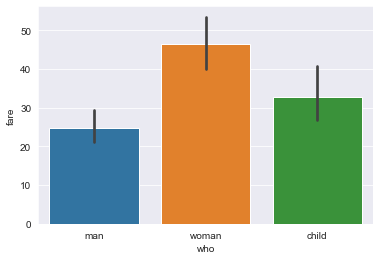

In [2]:
# importing the required library
import seaborn as sns
import matplotlib.pyplot as plt

# read a titanic.csv file
# from seaborn library
df = sns.load_dataset('titanic')

# who v/s fare barplot
sns.barplot(x = 'who',
            y = 'fare',
            data = df)

# Show the plot
plt.show()

In [10]:
sg.Window.get_screen_size()


(2560, 1440)

In [11]:
import os


def delete_desktop_ini(path=r".git"):
    # import dev_files.dev_tools as dtools
    desktopini_file = 'desktop.ini'
    for root, dirs, files in os.walk(path):
        desktop_inis = [f.lower() for f in files if f.lower().startswith(desktopini_file)]
        if desktop_inis:
            remove_path = os.path.join(root, desktop_inis[0])
            os.remove(remove_path)
            print(f"Removed File:\n{remove_path}\n")

delete_desktop_ini(r"C:\Users\adankert\Google Drive\GitHub\archives_archiver")

Removed File:
C:\Users\adankert\Google Drive\GitHub\archives_archiver\.git\objects\23\desktop.ini

Removed File:
C:\Users\adankert\Google Drive\GitHub\archives_archiver\.git\objects\3f\desktop.ini

Removed File:
C:\Users\adankert\Google Drive\GitHub\archives_archiver\.git\objects\7e\desktop.ini



In [9]:
import PySimpleGUI as sg

sg.Window.get_screen_size()


(2560, 1440)